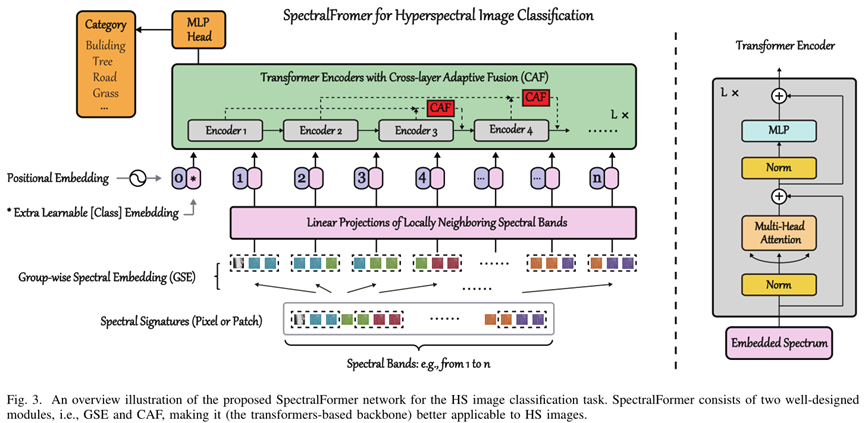

In [2]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 500 kB/s 


In [3]:
import torch
import torch.nn as nn
import numpy as np
from einops import rearrange, repeat

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads, dim_head, dropout):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x, mask = None):
        # x:[b,n,dim]
        b, n, _, h = *x.shape, self.heads

        # get qkv tuple:([b,n,head_num*head_dim],[...],[...])
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        # split q,k,v from [b,n,head_num*head_dim] -> [b,head_num,n,head_dim]
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        # transpose(k) * q / sqrt(head_dim) -> [b,head_num,n,n]
        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        mask_value = -torch.finfo(dots.dtype).max

        # mask value: -inf
        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, mask_value)
            del mask

        # softmax normalization -> attention matrix
        attn = dots.softmax(dim=-1)
        # value * attention matrix -> output
        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        # cat all output -> [b, n, head_num*head_dim]
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_head, dropout, num_channel, mode):
        super().__init__()
        
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_head, dropout = dropout)))
            ]))

        self.mode = mode
        self.skipcat = nn.ModuleList([])
        for _ in range(depth-2):
            self.skipcat.append(nn.Conv2d(num_channel+1, num_channel+1, [1, 2], 1, 0))

    def forward(self, x, mask = None):
        if self.mode == 'ViT':
            for attn, ff in self.layers:
                x = attn(x, mask = mask)
                x = ff(x)
        elif self.mode == 'CAF':
            last_output = []
            nl = 0
            for attn, ff in self.layers:           
                last_output.append(x)
                if nl > 1:             
                    x = self.skipcat[nl-2](torch.cat([x.unsqueeze(3), last_output[nl-2].unsqueeze(3)], dim=3)).squeeze(3)
                x = attn(x, mask = mask)
                x = ff(x)
                nl += 1

        return x

class ViT(nn.Module):
    def __init__(self, image_size, near_band, num_patches, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=1, dim_head = 16, dropout=0., emb_dropout=0., mode='ViT'):
        super().__init__()

        patch_dim = image_size ** 2 * near_band
        
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout, num_patches, mode)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
    def forward(self, x, mask = None):
       
        # patchs[batch, patch_num, patch_size*patch_size*c]  [batch,200,145*145]
        # x = rearrange(x, 'b c h w -> b c (h w)')

        ## embedding every patch vector to embedding size: [batch, patch_num, embedding_size]
        x = self.patch_to_embedding(x) #[b,n,dim]
        b, n, _ = x.shape

        # add position embedding
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b) #[b,1,dim]
        x = torch.cat((cls_tokens, x), dim = 1) #[b,n+1,dim]
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        # transformer: x[b,n + 1,dim] -> x[b,n + 1,dim]
        x = self.transformer(x, mask)

        # classification: using cls_token output
        x = self.to_latent(x[:,0])

        # MLP classification layer
        return self.mlp_head(x)

In [4]:
import torch
import argparse
import torch.nn as nn
import torch.utils.data as Data
import torch.backends.cudnn as cudnn
from scipy.io import loadmat
from scipy.io import savemat
from torch import optim
from torch.autograd import Variable
#from vit_pytorch import ViT
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import time
import os

TR.shape (145, 145)
TE.shape (145, 145)
label: (145, 145)
num_classes: 16
input_normalize: (145, 145, 200)
height=145,width=145,band=200
(50, 2)
**************************************************
total_pos_train.shape: (695, 2) | total_pos_train.type: <class 'numpy.ndarray'>
number_train: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 15, 15, 15] | number_train.type: <class 'list'>
**************************************************
**************************************************
patch is : 1
mirror_image shape : [145,145,200]
**************************************************
input_normalize.shape: (145, 145, 200)
mirror_image.shape: (145, 145, 200)
_____________________# 汇总训练数据和测试数据_____________________
train_point.shape[0]: 695
x_train.shape: (695, 1, 1, 200)
x_train shape = (695, 1, 1, 200), type = float64
x_test  shape = (9671, 1, 1, 200), type = float64
x_true  shape = (21025, 1, 1, 200), type = float64
**************************************************
x_train_band shape

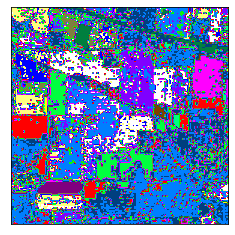

Final result:
OA: 0.6773 | AA: 0.7893 | Kappa: 0.6363
[0.57008671 0.59056122 0.85869565 0.86577181 0.83787661 0.88382688
 0.72004357 0.57444169 0.55319149 0.98148148 0.75803859 0.67878788
 1.         0.84615385 0.90909091 1.        ]
**************************************************
Parameter:
dataset: Indian
flag_test: test
mode: ViT
gpu_id: 0
seed: 0
batch_size: 16
test_freq: 5
patches: 1
band_patches: 1
epoches: 1000
learning_rate: 0.0008
gamma: 0.9
weight_decay: 0
f: /root/.local/share/jupyter/runtime/kernel-33148ae2-1543-48b9-9551-2ca33a53ae5b.json


In [14]:
import torch
import argparse
import torch.nn as nn
import torch.utils.data as Data
import torch.backends.cudnn as cudnn
from scipy.io import loadmat
from scipy.io import savemat
from torch import optim
from torch.autograd import Variable
#from vit_pytorch import ViT
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import time
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

parser = argparse.ArgumentParser("HSI")
parser.add_argument('--dataset', choices=['Indian', 'Pavia', 'Houston'], default='Indian', help='dataset to use')
parser.add_argument('--flag_test', choices=['train', 'train'], default='test', help='testing mark')
parser.add_argument('--mode', choices=['ViT', 'CAF'], default='ViT', help='mode choice')
parser.add_argument('--gpu_id', default='0', help='gpu id')
parser.add_argument('--seed', type=int, default=0, help='number of seed')
parser.add_argument('--batch_size', type=int, default=16, help='number of batch size')
parser.add_argument('--test_freq', type=int, default=5, help='number of evaluation')
parser.add_argument('--patches', type=int, default=1, help='number of patches')
parser.add_argument('--band_patches', type=int, default=1, help='number of related band')
parser.add_argument('--epoches', type=int, default=1000, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=8e-4, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.9, help='gamma')
parser.add_argument('--weight_decay', type=float, default=0, help='weight_decay')
parser.add_argument('-f')
args = parser.parse_args()


os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu_id)
#-------------------------------------------------------------------------------
# 定位训练和测试样本
def chooose_train_and_test_point(train_data, test_data, true_data, num_classes):
    number_train = []
    pos_train = {}
    number_test = []
    pos_test = {}
    number_true = []
    pos_true = {}
    #-------------------------for train data------------------------------------
    for i in range(num_classes):
        each_class = []
        each_class = np.argwhere(train_data==(i+1))#返回所有训练点索引
        number_train.append(each_class.shape[0])#训练点数目
        pos_train[i] = each_class#将训练位置索引赋值到pos_train字典中
    #print("pos_train][1](看看能不能输出标签为2的点位：)",pos_train[1])#可以
    total_pos_train = pos_train[0]#将标签值为1的点位位置赋予total_pos_train
    print(total_pos_train.shape)#50
    for i in range(1, num_classes):
        total_pos_train = np.r_[total_pos_train, pos_train[i]] #(695,2)。np.r_是按列连接两个矩阵，就是把两矩阵上下相加，要求列数相等
    total_pos_train = total_pos_train.astype(int)
    #--------------------------for test data------------------------------------
    for i in range(num_classes):
        each_class = []
        each_class = np.argwhere(test_data==(i+1))
        number_test.append(each_class.shape[0])
        pos_test[i] = each_class

    total_pos_test = pos_test[0]
    for i in range(1, num_classes):
        total_pos_test = np.r_[total_pos_test, pos_test[i]] #(9671,2)
    total_pos_test = total_pos_test.astype(int)
    #--------------------------for true data------------------------------------
    for i in range(num_classes+1):
        each_class = []
        each_class = np.argwhere(true_data==i)
        number_true.append(each_class.shape[0])
        pos_true[i] = each_class

    total_pos_true = pos_true[0]
    for i in range(1, num_classes+1):
        total_pos_true = np.r_[total_pos_true, pos_true[i]]
    total_pos_true = total_pos_true.astype(int)
    print("**************************************************")
    #total_pos_train训练数据的点位位置矩阵，number_train训练数据中每一类目标的数据列表
    print("total_pos_train.shape:",total_pos_train.shape,"| total_pos_train.type:",type(total_pos_train))
    print("number_train:",number_train,"| number_train.type:",type(number_train))
    print("**************************************************")

    return total_pos_train, total_pos_test, total_pos_true, number_train, number_test, number_true
#-------------------------------------------------------------------------------
# 边界拓展：镜像
def mirror_hsi(height,width,band,input_normalize,patch=5):
    padding=patch//2
    mirror_hsi=np.zeros((height+2*padding,width+2*padding,band),dtype=float)
    #中心区域
    mirror_hsi[padding:(padding+height),padding:(padding+width),:]=input_normalize
    #左边镜像
    for i in range(padding):
        mirror_hsi[padding:(height+padding),i,:]=input_normalize[:,padding-i-1,:]
    #右边镜像
    for i in range(padding):
        mirror_hsi[padding:(height+padding),width+padding+i,:]=input_normalize[:,width-1-i,:]
    #上边镜像
    for i in range(padding):
        mirror_hsi[i,:,:]=mirror_hsi[padding*2-i-1,:,:]
    #下边镜像
    for i in range(padding):
        mirror_hsi[height+padding+i,:,:]=mirror_hsi[height+padding-1-i,:,:]

    print("**************************************************")
    print("patch is : {}".format(patch))
    print("mirror_image shape : [{0},{1},{2}]".format(mirror_hsi.shape[0],mirror_hsi.shape[1],mirror_hsi.shape[2]))
    print("**************************************************")
    return mirror_hsi
#-------------------------------------------------------------------------------
# 获取patch的图像数据
def gain_neighborhood_pixel(mirror_image, point, i, patch=5):
    x = point[i,0]
    y = point[i,1]
    temp_image = mirror_image[x:(x+patch),y:(y+patch),:]
    return temp_image

def gain_neighborhood_band(x_train, band, band_patch, patch=5):
    nn = band_patch // 2
    pp = (patch*patch) // 2
    x_train_reshape = x_train.reshape(x_train.shape[0], patch*patch, band)
    x_train_band = np.zeros((x_train.shape[0], patch*patch*band_patch, band),dtype=float)
    # 中心区域
    x_train_band[:,nn*patch*patch:(nn+1)*patch*patch,:] = x_train_reshape
    #左边镜像
    for i in range(nn):
        if pp > 0:
            x_train_band[:,i*patch*patch:(i+1)*patch*patch,:i+1] = x_train_reshape[:,:,band-i-1:]
            x_train_band[:,i*patch*patch:(i+1)*patch*patch,i+1:] = x_train_reshape[:,:,:band-i-1]
        else:
            x_train_band[:,i:(i+1),:(nn-i)] = x_train_reshape[:,0:1,(band-nn+i):]
            x_train_band[:,i:(i+1),(nn-i):] = x_train_reshape[:,0:1,:(band-nn+i)]
    #右边镜像
    for i in range(nn):
        if pp > 0:
            x_train_band[:,(nn+i+1)*patch*patch:(nn+i+2)*patch*patch,:band-i-1] = x_train_reshape[:,:,i+1:]
            x_train_band[:,(nn+i+1)*patch*patch:(nn+i+2)*patch*patch,band-i-1:] = x_train_reshape[:,:,:i+1]
        else:
            x_train_band[:,(nn+1+i):(nn+2+i),(band-i-1):] = x_train_reshape[:,0:1,:(i+1)]
            x_train_band[:,(nn+1+i):(nn+2+i),:(band-i-1)] = x_train_reshape[:,0:1,(i+1):]
    return x_train_band
#-------------------------------------------------------------------------------
# 汇总训练数据和测试数据
def train_and_test_data(mirror_image, band, train_point, test_point, true_point, patch=5, band_patch=3):
    print("train_point.shape[0]:",train_point.shape[0])
    x_train = np.zeros((train_point.shape[0], patch, patch, band), dtype=float)
    print("x_train.shape:",x_train.shape)
    x_test = np.zeros((test_point.shape[0], patch, patch, band), dtype=float)
    x_true = np.zeros((true_point.shape[0], patch, patch, band), dtype=float)
    for i in range(train_point.shape[0]):#(695)
        x_train[i,:,:,:] = gain_neighborhood_pixel(mirror_image, train_point, i, patch)
    for j in range(test_point.shape[0]):
        x_test[j,:,:,:] = gain_neighborhood_pixel(mirror_image, test_point, j, patch)
    for k in range(true_point.shape[0]):
        x_true[k,:,:,:] = gain_neighborhood_pixel(mirror_image, true_point, k, patch)
    print("x_train shape = {}, type = {}".format(x_train.shape,x_train.dtype))
    print("x_test  shape = {}, type = {}".format(x_test.shape,x_test.dtype))
    print("x_true  shape = {}, type = {}".format(x_true.shape,x_test.dtype))
    print("**************************************************")
    
    x_train_band = gain_neighborhood_band(x_train, band, band_patch, patch)
    x_test_band = gain_neighborhood_band(x_test, band, band_patch, patch)
    x_true_band = gain_neighborhood_band(x_true, band, band_patch, patch)
    print("x_train_band shape = {}, type = {}".format(x_train_band.shape,x_train_band.dtype))
    print("x_test_band  shape = {}, type = {}".format(x_test_band.shape,x_test_band.dtype))
    print("x_true_band  shape = {}, type = {}".format(x_true_band.shape,x_true_band.dtype))
    print("**************************************************")
    return x_train_band, x_test_band, x_true_band
#-------------------------------------------------------------------------------
# 标签y_train, y_test
def train_and_test_label(number_train, number_test, number_true, num_classes):
    y_train = []
    y_test = []
    y_true = []
    for i in range(num_classes):
        for j in range(number_train[i]):
            y_train.append(i)
        for k in range(number_test[i]):
            y_test.append(i)
    for i in range(num_classes+1):
        for j in range(number_true[i]):
            y_true.append(i)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_true = np.array(y_true)
    print("y_train: shape = {} ,type = {}".format(y_train.shape,y_train.dtype))
    print("y_test: shape = {} ,type = {}".format(y_test.shape,y_test.dtype))
    print("y_true: shape = {} ,type = {}".format(y_true.shape,y_true.dtype))
    print("**************************************************")
    return y_train, y_test, y_true
#-------------------------------------------------------------------------------
class AvgrageMeter(object):

  def __init__(self):
    self.reset()

  def reset(self):
    self.avg = 0
    self.sum = 0
    self.cnt = 0

  def update(self, val, n=1):
    self.sum += val * n
    self.cnt += n
    self.avg = self.sum / self.cnt
#-------------------------------------------------------------------------------
def accuracy(output, target, topk=(1,)):
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
    correct_k = correct[:k].view(-1).float().sum(0)
    res.append(correct_k.mul_(100.0/batch_size))
  return res, target, pred.squeeze()
#-------------------------------------------------------------------------------
# train model
def train_epoch(model, train_loader, criterion, optimizer):
    objs = AvgrageMeter()
    top1 = AvgrageMeter()
    tar = np.array([])
    pre = np.array([])
    for batch_idx, (batch_data, batch_target) in enumerate(train_loader):
        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device) 

        optimizer.zero_grad()
        batch_pred = model(batch_data,mask = None)
        loss = criterion(batch_pred, batch_target)
        loss.backward()
        optimizer.step()
      

        prec1, t, p = accuracy(batch_pred, batch_target, topk=(1,))
        n = batch_data.shape[0]
        objs.update(loss.data, n)
        top1.update(prec1[0].data, n)
        tar = np.append(tar, t.data.cpu().numpy())
        pre = np.append(pre, p.data.cpu().numpy())
    return top1.avg, objs.avg, tar, pre
#-------------------------------------------------------------------------------
# validate model
def valid_epoch(model, valid_loader, criterion, optimizer):
    objs = AvgrageMeter()
    top1 = AvgrageMeter()
    tar = np.array([])
    pre = np.array([])
    for batch_idx, (batch_data, batch_target) in enumerate(valid_loader):
        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device) 

        batch_pred = model(batch_data)
        
        loss = criterion(batch_pred, batch_target)

        prec1, t, p = accuracy(batch_pred, batch_target, topk=(1,))
        n = batch_data.shape[0]
        objs.update(loss.data, n)
        top1.update(prec1[0].data, n)
        tar = np.append(tar, t.data.cpu().numpy())
        pre = np.append(pre, p.data.cpu().numpy())
        
    return tar, pre

def test_epoch(model, test_loader, criterion, optimizer):
    objs = AvgrageMeter()
    top1 = AvgrageMeter()
    tar = np.array([])
    pre = np.array([])
    for batch_idx, (batch_data, batch_target) in enumerate(test_loader):
        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device) 

        batch_pred = model(batch_data)

        _, pred = batch_pred.topk(1, 1, True, True)
        pp = pred.squeeze()
        pre = np.append(pre, pp.data.cpu().numpy())
    return pre
#-------------------------------------------------------------------------------
def output_metric(tar, pre):
    matrix = confusion_matrix(tar, pre)
    OA, AA_mean, Kappa, AA = cal_results(matrix)
    return OA, AA_mean, Kappa, AA
#-------------------------------------------------------------------------------
def cal_results(matrix):
    shape = np.shape(matrix)
    number = 0
    sum = 0
    AA = np.zeros([shape[0]], dtype=float)
    for i in range(shape[0]):
        number += matrix[i, i]
        AA[i] = matrix[i, i] / np.sum(matrix[i, :])
        sum += np.sum(matrix[i, :]) * np.sum(matrix[:, i])
    OA = number / np.sum(matrix)
    AA_mean = np.mean(AA)
    pe = sum / (np.sum(matrix) ** 2)
    Kappa = (OA - pe) / (1 - pe)
    return OA, AA_mean, Kappa, AA
#-------------------------------------------------------------------------------
# Parameter Setting
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
cudnn.deterministic = True
cudnn.benchmark = False
# prepare data
if args.dataset == 'Indian':
    data = loadmat('/content/drive/MyDrive/AI data/SpectralFormer/IndianPine.mat')
elif args.dataset == 'Pavia':
    data = loadmat('/content/drive/MyDrive/AI data/hyperspetral image/PaviaU.mat')
#elif args.dataset == 'Houston':
#    data = loadmat('./data/Houston.mat')
else:
    raise ValueError("Unkknow dataset")
color_mat = loadmat('/content/drive/MyDrive/AI data/SpectralFormer/AVIRIS_colormap.mat')
TR = data['TR']
print("TR.shape",TR.shape)

TE = data['TE']
print("TE.shape",TE.shape)

input = data['input'] #(145,145,200)
label = TR + TE
print("label:",label.shape)
num_classes = np.max(TR)
print("num_classes:",num_classes)

color_mat_list = list(color_mat)
color_matrix = color_mat[color_mat_list[3]] #(17,3)
# normalize data by band norm
input_normalize = np.zeros(input.shape)
print("input_normalize:",input_normalize.shape)
for i in range(input.shape[2]):
    input_max = np.max(input[:,:,i])
    input_min = np.min(input[:,:,i])
    input_normalize[:,:,i] = (input[:,:,i]-input_min)/(input_max-input_min)
# data size
height, width, band = input.shape
print("height={0},width={1},band={2}".format(height, width, band))
#-------------------------------------------------------------------------------
# obtain train and test data
total_pos_train, total_pos_test, total_pos_true, number_train, number_test, number_true = chooose_train_and_test_point(TR, TE, label, num_classes)
# 定位训练和测试样本
#total_pos_train训练数据的点位位置矩阵，number_train训练数据中每一类目标的数据列表。
#total_pos_test，total_pos_truenumber_test, number_true同理
mirror_image = mirror_hsi(height, width, band, input_normalize, patch=args.patches)
print("input_normalize.shape:",input_normalize.shape)
print("mirror_image.shape:",mirror_image.shape)
print("_____________________# 汇总训练数据和测试数据_____________________")
x_train_band, x_test_band, x_true_band = train_and_test_data(mirror_image, band, total_pos_train, total_pos_test, total_pos_true, patch=args.patches, band_patch=args.band_patches)
y_train, y_test, y_true = train_and_test_label(number_train, number_test, number_true, num_classes)
#-------------------------------------------------------------------------------
# load data
x_train=torch.from_numpy(x_train_band.transpose(0,2,1)).type(torch.FloatTensor) #[695, 200, 7, 7]
y_train=torch.from_numpy(y_train).type(torch.LongTensor) #[695]
Label_train=Data.TensorDataset(x_train,y_train)
x_test=torch.from_numpy(x_test_band.transpose(0,2,1)).type(torch.FloatTensor) # [9671, 200, 7, 7]
y_test=torch.from_numpy(y_test).type(torch.LongTensor) # [9671]
Label_test=Data.TensorDataset(x_test,y_test)
x_true=torch.from_numpy(x_true_band.transpose(0,2,1)).type(torch.FloatTensor)
y_true=torch.from_numpy(y_true).type(torch.LongTensor)
Label_true=Data.TensorDataset(x_true,y_true)
print("__________________________loda data__________________________")
print("**************************************************************")
print("x_train.shape:",x_train.shape)
print("y_train.shape:",y_train.shape)
#print("Label_train.shape",Label_train.shape)
print("x_test.shape:",x_test.shape)
print("y_test.shape:",y_test.shape)
#print("Label_test.shape:",Label_test.shape)
print("x_true.shape:",x_true.shape)
print("y_true.shape:",y_true.shape)
#print("Label_true.shape:",Label_true.shape)
print("**************************************************************")

label_train_loader=Data.DataLoader(Label_train,batch_size=args.batch_size,shuffle=True)
label_test_loader=Data.DataLoader(Label_test,batch_size=args.batch_size,shuffle=True)
label_true_loader=Data.DataLoader(Label_true,batch_size=100,shuffle=False)

#-------------------------------------------------------------------------------
# create model
model = ViT(
    image_size = args.patches,
    near_band = args.band_patches,
    num_patches = band,
    num_classes = num_classes,
    dim = 64,
    depth = 5,
    heads = 4,
    mlp_dim = 8,
    dropout = 0.1,
    emb_dropout = 0.1,
    mode = args.mode
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# criterion
criterion = nn.CrossEntropyLoss().to(device)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.epoches//10, gamma=args.gamma)
#-------------------------------------------------------------------------------
if args.flag_test == 'test':
    if args.mode == 'ViT':
        model=torch.load('/content/model_995.pth',map_location=torch.device("cuda:0"))     
    elif (args.mode == 'CAF') & (args.patches == 1):
        model.load_state_dict(torch.load('./SpectralFormer_pixel.pt'))
    elif (args.mode == 'CAF') & (args.patches == 7):
        model.load_state_dict(torch.load('./SpectralFormer_patch.pt'))
    else:
        raise ValueError("Wrong Parameters") 
    model.eval()
    tar_v, pre_v = valid_epoch(model, label_test_loader, criterion, optimizer)
    OA2, AA_mean2, Kappa2, AA2 = output_metric(tar_v, pre_v)

    # output classification maps
    pre_u = test_epoch(model, label_true_loader, criterion, optimizer)
    prediction_matrix = np.zeros((height, width), dtype=float)
    for i in range(total_pos_true.shape[0]):
        prediction_matrix[total_pos_true[i,0], total_pos_true[i,1]] = pre_u[i] + 1
    plt.subplot(1,1,1)
    plt.imshow(prediction_matrix, colors.ListedColormap(color_matrix))
    plt.xticks([])
    plt.yticks([])
    plt.show()
    savemat('matrix.mat',{'P':prediction_matrix, 'label':label})
elif args.flag_test == 'train':
    print("start training")
    tic = time.time()
    for epoch in range(args.epoches): 
        scheduler.step()

        # train model
        model.train()
        train_acc, train_obj, tar_t, pre_t = train_epoch(model, label_train_loader, criterion, optimizer)
        OA1, AA_mean1, Kappa1, AA1 = output_metric(tar_t, pre_t) 
        print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}"
                        .format(epoch+1, train_obj, train_acc))
        

        if (epoch % args.test_freq == 0) | (epoch == args.epoches - 1):         
            model.eval()
            tar_v, pre_v = valid_epoch(model, label_test_loader, criterion, optimizer)
            OA2, AA_mean2, Kappa2, AA2 = output_metric(tar_v, pre_v)
        if epoch > 990:
          torch.save(model,"model_{}.pth".format(epoch))
          print("................第{}轮迭代模型已保存...............".format(epoch))
    toc = time.time()
    print("Running Time: {:.2f}".format(toc-tic))
    
    print("**************************************************")

print("Final result:")
print("OA: {:.4f} | AA: {:.4f} | Kappa: {:.4f}".format(OA2, AA_mean2, Kappa2))
print(AA2)
print("**************************************************")
print("Parameter:")

def print_args(args):
    for k, v in zip(args.keys(), args.values()):
        print("{0}: {1}".format(k,v))

print_args(vars(args))

In [6]:
print(type(input))
input1=input[:,:,0:1]
print(input1.shape)
input1 = input1.reshape(145,145)
print(input1.shape)

<class 'numpy.ndarray'>
(145, 145, 1)
(145, 145)


In [7]:
print(type(TR))
import xlwt  # 负责写excel
import xlrd
filename =xlwt.Workbook() #创建工作簿
sheet1 = filename.add_sheet(u'sheet1',cell_overwrite_ok=True) #创建sheet
[h,l]=TR.shape #h为行数，l为列数
for i in range (h):
    for j in range (l):
      sheet1.write(i,j,int(TR[i,j]))
filename.save('name_of_your_excel_fileTR.xls')


<class 'numpy.ndarray'>
